In [2]:

# resize_images_512x512.py

# 1 This splits the original Kvasir-SEG: A Segmented Polyp Dataset 
# to three subsets train, test and valid. 
# https://paperswithcode.com/dataset/kvasir-seg

# 2 Resize all image and masks to 512x512
#

#    
import sys
import os
import glob
from PIL import Image, ImageOps
import random
import shutil
import traceback
import cv2
import numpy as np

# 2024/01/22
W = 512  # 256
H = 512  # 256


def resize_images(images_dir, masks_dir, output_dir):
    pattern = images_dir + "/*.jpg"

    print("--- pattern {}".format(pattern))
    image_files = glob.glob(pattern)
    num_files = len(image_files)
    # 1 shuffle mask_files
    random.shuffle(image_files)

    # 2 Compute the number of images to split
    # train= 0.8 test=0.2 
    num_train = int(num_files * 0.7)
    num_valid = int(num_files * 0.2)
    num_test = int(num_files * 0.1)

    train_files = image_files[0: num_train]
    valid_files = image_files[num_train: num_train + num_valid]
    test_files = image_files[num_train + num_valid:]

    print("=== number of train_files {}".format(len(train_files)))
    print("=== number of valid_files {}".format(len(valid_files)))
    print("=== number of test_files  {}".format(len(test_files)))

    # 3 Resize images and masks 
    create_resized_files(train_files, masks_dir, output_dir, "train")
    create_resized_files(valid_files, masks_dir, output_dir, "valid")
    # 4 If test generated_dataset, save the original file to output + "test" dir.

    create_resized_files(test_files, masks_dir, output_dir, "test")


def create_resized_files(image_files, masks_dir, output_dir, dataset):
    # target = train_or_test_or_valid_dir:

    output_subdir = os.path.join(output_dir, dataset)
    if os.path.exists(output_subdir):
        shutil.rmtree(output_subdir)

    if not os.path.exists(output_subdir):
        os.makedirs(output_subdir)

    output_images_dir = os.path.join(output_subdir, "images")
    if not os.path.exists(output_images_dir):
        os.makedirs(output_images_dir)

    output_masks_dir = os.path.join(output_subdir, "masks")
    if not os.path.exists(output_masks_dir):
        os.makedirs(output_masks_dir)

    for image_file in image_files:
        basename = os.path.basename(image_file)

        nameonly = basename.split(".")[0]
        mask_file = os.path.join(masks_dir, basename)
        image = Image.open(image_file).convert("RGB")

        mask = Image.open(mask_file).convert("L")
        """
        if generated_dataset == "test":
          shutil.copy2(image_file, output_images_dir)
          shutil.copy2(mask_file,  output_masks_dir)
          continue
    
        else:
        """
        w, h = image.size
        size = w
        if h >= w:
            size = h
        px = int((size - w) / 2)
        py = int((size - h) / 2)

        image_background = Image.new("RGB", (size, size), (0, 0, 0))
        image_background.paste(image, (px, py))

        mask_background = Image.new("L", (size, size))
        mask_background.paste(mask, (px, py))
        resized_image = image_background.resize((W, H))
        resized_mask = mask_background.resize((W, H))

        ANGLES = [0, 90, 180, 270]

        for angle in ANGLES:
            rotated_image = resized_image.rotate(angle)
            rotated_mask = resized_mask.rotate(angle)
            output_filename = "rotated_" + str(angle) + "_" + basename

            rotated_image_file = os.path.join(output_images_dir, output_filename)
            rotated_image.save(rotated_image_file)
            rotated_mask_file = os.path.join(output_masks_dir, output_filename)
            rotated_mask.save(rotated_mask_file)

        # flipp
        flipped_image = ImageOps.flip(resized_image)
        flipped_mask = ImageOps.flip(resized_mask)
        output_filename = "flipped_" + basename

        flipped_image_file = os.path.join(output_images_dir, output_filename)
        flipped_image.save(flipped_image_file)
        flipped_mask_file = os.path.join(output_masks_dir, output_filename)
        flipped_mask.save(flipped_mask_file)

        # mirror
        mirrored_image = ImageOps.mirror(resized_image)
        mirrored_mask = ImageOps.mirror(resized_mask)

        output_filename = "mirrored_" + basename

        mirrored_image_file = os.path.join(output_images_dir, output_filename)
        mirrored_image.save(mirrored_image_file)
        mirrored_mask_file = os.path.join(output_masks_dir, output_filename)
        mirrored_mask.save(mirrored_mask_file)


"""
input_dir
Kvasir-SEG
 +-- images
 +-- masks

ouput_directory struture

"./generated_dataset"
 +-- test
 |     +--images
 |     +--mask
 +-- train
 |     +--images
 |     +--mask
 +-- valid
       +--images
       +--mask

 """

if __name__ == "__main__":
    try:
        images_dir = "./Kvasir-SEG/images"
        masks_dir = "./Kvasir-SEG/masks"
        output_dir = "generated_dataset"
        if not os.path.exists(images_dir):
            raise Exception("===NOT FOUND " + images_dir)
        if not os.path.exists(masks_dir):
            raise Exception("===NOT FOUND " + masks_dir)

        if os.path.exists(output_dir):
            shutil.rmtree(output_dir)
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)

        # create_master_512x512 generated_dataset train, test
        # from the orignal SEG .
        resize_images(images_dir, masks_dir, output_dir)

    except:
        traceback.print_exc()

# %%


--- pattern ./Kvasir-SEG/images/*.jpg
=== number of train_files 700
=== number of valid_files 200
=== number of test_files  100


In [4]:
#
# detect_polyp.py for generated_dataset generated_dataset
# Create  annotation from the jpg segementation generated_dataset
#  test
#   +--images
#   +--masks
#  train
#   +--images
#   +--masks
#  valid
#   +--images
#   +--masks


import sys
import os
import glob
import random
import shutil
import numpy as np

import traceback
import cv2
from PIL import Image


class PolypImageDetectAnnotater:
    def __init__(self, W=512, H=512):
        self.W = W
        self.H = H

    # target = "./train", "./valid", "test"
    def generate(self, input_dir, output_dir, debug=False):
        images_dir = input_dir + "/images/"
        masks_dir = input_dir + "/masks/"
        image_filepaths = glob.glob(images_dir + "/*.jpg")
        if os.path.exists(output_dir):
            shutil.rmtree(output_dir)

        if not os.path.exists(output_dir):
            os.makedirs(output_dir)

        for image_filepath in image_filepaths:
            basename = os.path.basename(image_filepath)
            name = basename.split(".")[0]

            # 1 Create resize_image of size 512x512
            img_512x512 = self.create_resized_images(image_filepath)

            output_img_filepath = os.path.join(output_dir, basename)
            # 2 Save the img_512x512 as a jpg file.
            img_512x512.save(output_img_filepath)

            # 3 Get some mask_filepaths corresponding to the image_filepath
            mask_filepaths = glob.glob(masks_dir + basename)
            SP = " "

            class_id = 0
            annotations = []

            for mask_filepath in mask_filepaths:
                # PIL image format
                mask_img_512x512 = self.create_resized_images(mask_filepath, mask=True)

                # 5 Create a yolo annotation from the mask_img.
                (rcx, rcy, rw, rh) = self.create_yolo_annotation(mask_img_512x512)
                annotations.append((rcx, rcy, rw, rh))

            annotation_file = name + ".txt"
            annotation_file_path = os.path.join(output_dir, annotation_file)
            if debug:
                self.create_annotated_image(class_id, img_512x512, annotations, basename, output_dir)

            NL = "\n"
            # 6 Create a yolo annotation file.
            with open(annotation_file_path, "w") as f:
                for annotation in annotations:
                    (rcx, rcy, rw, rh) = annotation
                    line = str(class_id) + SP + str(rcx) + SP + str(rcy) + SP + str(rw) + SP + str(rh)

                    f.writelines(line + NL)

    # Create a resized_512x512_image from each original file in image_filepaths
    def create_resized_images(self, image_filepath, mask=False):
        img = Image.open(image_filepath)
        resized_512x512_image = img.resize((self.W, self.H))
        resized_512x512_image = resized_512x512_image.convert("RGB")

        if mask:
            resized_512x512_image = self.convert2WhiteMask(resized_512x512_image)

        return resized_512x512_image

    def create_yolo_annotation(self, pil_mask_img_512x512):
        mask_img = np.array(pil_mask_img_512x512)

        mask_img = cv2.cvtColor(mask_img, cv2.COLOR_RGB2GRAY)

        H, W = mask_img.shape[:2]

        contours, hierarchy = cv2.findContours(mask_img,
                                               cv2.RETR_EXTERNAL,
                                               cv2.CHAIN_APPROX_SIMPLE)

        contours = max(contours, key=lambda x: cv2.contourArea(x))
        x, y, w, h = cv2.boundingRect(contours)
        # Compute bouding box of YOLO format.
        cx = x + w / 2
        cy = y + h / 2
        # Convert to relative coordinates for YOLO annotations
        rcx = round(cx / W, 5)
        rcy = round(cy / H, 5)
        rw = round(w / W, 5)
        rh = round(h / H, 5)

        return (rcx, rcy, rw, rh)

    def convert2WhiteMask(self, image):
        w, h = image.size
        for y in range(h):
            for x in range(w):
                pixel = image.getpixel((x, y))
                if pixel != (0, 0, 0):
                    pixel = (255, 255, 255)  # White
                    image.putpixel((x, y), pixel)
        return image

    def create_annotated_image(self, class_id, _non_mask_img, annotations, basename, output_subdir):
        _non_mask_img = np.array(_non_mask_img)

        GREEN = (0, 255, 0)
        YELLOW = (0, 255, 255)
        output_dir_annotated = os.path.join(output_subdir, "diseases")
        if not os.path.exists(output_dir_annotated):
            os.makedirs(output_dir_annotated)
        for annotation in annotations:
            (rcx, rcy, rw, rh) = annotation
            cx = int(rcx * self.W)
            cy = int(rcy * self.H)
            w = int(rw * self.W)
            h = int(rh * self.H)
            x = int(cx - w / 2)
            y = int(cy - h / 2)
            _non_mask_img = cv2.rectangle(_non_mask_img, (x, y), (x + w, y + h), GREEN, 2)
            """
      cv2.putText(_non_mask_img,
              text      = str(class_id),
              org       = (x, y-30),
              fontFace  = cv2.FONT_HERSHEY_SIMPLEX,
              fontScale = 0.5,
              color     = YELLOW,
              thickness = 2)
      """
            ouput_image_file_annotated = os.path.join(output_dir_annotated, basename)
            _non_mask_img = cv2.cvtColor(_non_mask_img, cv2.COLOR_RGB2BGR)
            cv2.imwrite(ouput_image_file_annotated, _non_mask_img)


"""
Example for Skin-Lesion

INPUT:

./generated_dataset
├─test
├─train
└─valid


Output:
./DetectedPolyps
├─test
├─train
└─valid

"""

if __name__ == "__main__":
    input_dir = "generated_dataset"
    try:
        # if len(sys.argv) == 1:
        #     raise Exception("Please specify input_dir on command line.")
        if len(sys.argv) == 2:
            input_dir = sys.argv[1]
        if not os.path.exists(input_dir):
            raise Exception("Not found " + input_dir)

        datasets = ["train", "valid", "test"]
        output_dir = "./DetectedPolyps"

        if os.path.exists(output_dir):
            shutil.rmtree(output_dir)
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)

        annotation = PolypImageDetectAnnotater(W=512, H=512)
        debug = True
        for dataset in datasets:
            input_subdir = os.path.join(input_dir, dataset)
            output_subdir = os.path.join(output_dir, dataset)

            annotation.generate(input_subdir, output_subdir, debug=debug)

        print("All finished")
    except:
        traceback.print_exc()



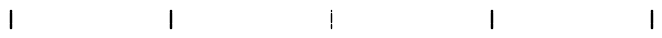

In [18]:
# show images
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
output_dir = "./DetectedPolyps/train/diseases"
images = []
for img_path in glob.glob(output_dir + '/*.jpg'):
    images.append(mpimg.imread(img_path))

columns = 5
rows = int(len(images) / columns)
plt.figure(figsize=(10, 10))

for i, image in enumerate(images):
    if i == 100:
        break
    plt.subplot(rows, columns, i + 1)
    rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(rgb, cmap=plt.set_cmap("Spectral"))
    plt.xticks([])
    plt.yticks([])
